# Random Forest
## Table of Contents
* [Bibliotecas](#Bibliotecas-(Libraries))
* [Leitura dos Dados](#Leitura-dos-Dados)
* [Buscando os Melhores Hiperparâmetros](#Buscando-os-Melhores-Hiperparâmetros)
* [Florestas Aleatórias](#Florestas-Aleatórias)
* [Análise de Erro](#Análise-de-Erro)
* [Retreinando o Modelo](#Retreinando-o-Modelo)
* [Criando o Resultado](#Criando-o-Resultado-das-Previsões-para-Importar-ao-Kaggle)

## Bibliotecas (Libraries)

In [4]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from skopt import gp_minimize

## Leitura dos Dados
Lendo o training e o test set, e conferindo as suas dimensões.

In [6]:
X_train_pre, X_test = pd.read_csv('../data/preprocessed/train.csv'), pd.read_csv('../data/preprocessed/test.csv')
print(f'Train set shape: {X_train_pre.shape}\nTest set shape: {X_test.shape}')

Train set shape: (891, 29)
Test set shape: (418, 28)


Lendo os 5 primeiros exemplos do training set.

In [8]:
X_train_pre.head()

,Sex_b,Age_pre,Pclass,Embarked_S,Embarked_C,SibSp,Parch,Fare,Cabin_null,Cabin_C,...,Name_Master,Name_Col,Name_Major,Name_Mr,Name_Dr,Name_Don,Name_Sir,Ticket_num,Ticket_cat,Survived
0,0,22.0,3,1,0,1,0,7.2500,1,0,...,0,0,0,1,0,0,0,21171,0,0
1,1,38.0,1,0,0,1,0,71.2833,0,1,...,0,0,0,1,0,0,0,17599,1,1
2,1,26.0,3,1,0,0,0,7.9250,1,0,...,0,0,0,0,0,0,0,3101282,2,1
3,1,35.0,1,1,0,1,0,53.1000,0,1,...,0,0,0,1,0,0,0,113803,3,1
4,0,35.0,3,1,0,0,0,8.0500,1,0,...,0,0,0,1,0,0,0,373450,4,0


Separando as features $X$ e o target $y$ para a criação do modelo.

In [10]:
y = X_train_pre['Survived'].copy()
X = X_train_pre.drop(columns=['Survived'], axis=1).copy()

## Buscando os Melhores Hiperparâmetros
Utilizando o método bayesian optimization para buscar os melhores hiperparâmetros para o modelo.

In [12]:
def fit_model(hparams):    
    model = RandomForestClassifier(
        n_estimators=hparams[0],
        max_depth=hparams[1],
        min_samples_split=hparams[2],
        n_jobs=-1,
        random_state=42
    )
    model.fit(X_opt, y)
    
    yhat_train = model.predict(X_opt)
    
    return -accuracy_score(yhat_train, y)

Definindo o espaço de cada hiperparâmetro para o modelo avaliar o desempenho do modelo em cada espaço de cada hiperparâmetro e retornando a melhor combinação, então, depois escalamos os dados, executamos a otimização dos hiperparâmetros e visualizamos a melhor combinação dos hiperparâmetros.

In [14]:
space = [
    (100, 500), # n_estimators
    (250, 500), # max_depth
    (2, 25), # min_samples_split
]

X_opt = StandardScaler().fit_transform(X)
opt = gp_minimize(fit_model, space, random_state=42, verbose=0, n_calls=50, n_random_starts=20)
opt.x

[np.int64(347), np.int64(403), np.int64(2)]

## Florestas Aleatórias
Criando, treinando o modelo no fold do training set e avaliando o modelo nos folds de training e dev set.

As avaliações no training e dev set estão sendo adicionadas em uma lista para depois serem plotadas.

In [16]:
kf = RepeatedKFold(n_splits=2, n_repeats=10, random_state=42)

scaler = StandardScaler()

step_train = []
step_cv = []
i = 0

for linhas_train, linhas_cv in kf.split(X):
    X_train, X_cv = X.iloc[linhas_train].copy(), X.iloc[linhas_cv].copy()
    y_train, y_cv = y.iloc[linhas_train].copy(), y.iloc[linhas_cv].copy()
    
    X_train = scaler.fit_transform(X_train)
    X_cv = scaler.transform(X_cv)

    model = RandomForestClassifier(
        n_estimators=200, 
        n_jobs=-1,
        random_state=42,
        max_depth=3,
        min_samples_split=5
    )
    model.fit(X_train, y_train)

    yhat_train = model.predict(X_train)
    yhat_cv = model.predict(X_cv)

    acc_train = np.mean(y_train == yhat_train)
    acc_cv = np.mean(y_cv == yhat_cv)

    if i % 10 == 0:
        print(f'acc_train: {acc_train:.4f}, acc_cv: {acc_cv:.4f}\n')

    step_train.append(acc_train)
    step_cv.append(acc_cv)
    i += 1

print(f'{"=" * 35}\n\nTrain mean: {np.mean(step_train):.2f}, CV mean: {np.mean(step_cv):.2f}')

acc_train: 0.8494, acc_cv: 0.7960

acc_train: 0.8315, acc_cv: 0.7848


Train mean: 0.84, CV mean: 0.80


Plotando o histórico do desempenho no training e no dev set.

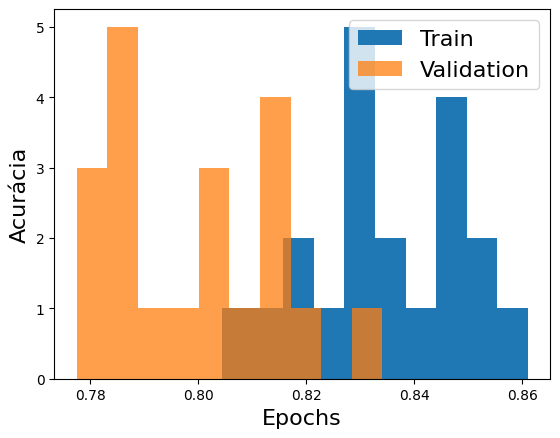

In [18]:
plt.hist(step_train, label='Train')
plt.hist(step_cv, label='Validation', alpha=.75)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Acurácia', fontsize=16)
plt.legend(loc='best', fontsize=16)
plt.grid(False)
plt.show()

Realizando a predição no test set.

In [50]:
X_test_pre = scaler.transform(X_test)
yhat = model.predict(X_test_pre)

## Análise de Erro
Executando a análise de erro nas previsões.

In [53]:
train = pd.read_csv('../data/raw/train.csv')
features = [c for c in X_train_pre.columns if c not in train.columns]
train = pd.concat([train, X_train_pre[features]], axis=1)

X_cv_erro = train.loc[linhas_cv].copy()
X_cv_erro['yhat'] = yhat_cv
X_cv_erro.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Name_Master,Name_Col,Name_Major,Name_Mr,Name_Dr,Name_Don,Name_Sir,Ticket_num,Ticket_cat,yhat
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,0,0,0,1,0,0,0,17599,1,1
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,...,0,0,0,1,0,0,0,17463,6,0
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,...,0,0,0,1,0,0,0,347742,8,0
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,...,0,0,0,0,0,0,0,9549,10,1
11,12,1,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,...,0,0,0,0,0,0,0,113783,11,1


Definindo as previsões incorretas e, definindo e ordenando as features para leitura do dataset.

In [56]:
erro = X_cv_erro[X_cv_erro['Survived'] != X_cv_erro['yhat']]
erro = erro[['Survived', 'yhat', 'Name', 'Cabin', 'Embarked', 'Sex', 'Sex_b', 'Age', 'Age_pre', 'Pclass', 'Embarked_S',
             'Embarked_C', 'SibSp', 'Parch', 'Fare', 'Cabin_null',
             'Cabin_C', 'Cabin_E', 'Cabin_G', 'Cabin_D', 'Cabin_A', 'Cabin_B', 'Cabin_F', 'Cabin_T',
             'Name_Miss', 'Name_Mrs', 'Name_Master', 'Name_Col', 'Name_Major', 'Name_Mr', 'Name_Dr', 'Name_Don', 'Name_Sir']]
erro.head()

,Survived,yhat,Name,Cabin,Embarked,Sex,Sex_b,Age,Age_pre,Pclass,...,Cabin_T,Name_Miss,Name_Mrs,Name_Master,Name_Col,Name_Major,Name_Mr,Name_Dr,Name_Don,Name_Sir
8,1,0,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",NaN,S,female,1,27.0,27.0,3,...,0,0,1,0,0,0,1,0,0,0
17,1,0,"Williams, Mr. Charles Eugene",NaN,S,male,0,NaN,29.0,2,...,0,0,0,0,0,0,1,0,0,0
18,0,1,"Vander Planke, Mrs. Julius (Emelia Maria Vande...",NaN,S,female,1,31.0,31.0,3,...,0,0,1,0,0,0,1,0,0,0
23,1,0,"Sloper, Mr. William Thompson",A6,S,male,0,28.0,28.0,1,...,0,0,0,0,0,0,1,0,0,0
25,1,0,"Asplund, Mrs. Carl Oscar (Selma Augusta Emilia...",NaN,S,female,1,38.0,38.0,3,...,0,0,1,0,0,0,1,0,0,0


Separando os erros entre a classe `male` e `female`.

In [59]:
female = erro[erro['Sex_b'] == 1]
male = erro[erro['Sex_b'] == 0]

Ordenando os erros da classe `female` pelo target $y$.

In [62]:
female.sort_values('Survived')

,Survived,yhat,Name,Cabin,Embarked,Sex,Sex_b,Age,Age_pre,Pclass,...,Cabin_T,Name_Miss,Name_Mrs,Name_Master,Name_Col,Name_Major,Name_Mr,Name_Dr,Name_Don,Name_Sir
18,0,1,"Vander Planke, Mrs. Julius (Emelia Maria Vande...",NaN,S,female,1,31.0,31.0,3,...,0,0,1,0,0,0,1,0,0,0
49,0,1,"Arnold-Franchi, Mrs. Josef (Josefine Franchi)",NaN,S,female,1,18.0,18.0,3,...,0,0,1,0,0,0,1,0,0,0
111,0,1,"Zabour, Miss. Hileni",NaN,C,female,1,14.5,14.5,3,...,0,1,0,0,0,0,0,0,0,0
100,0,1,"Petranec, Miss. Matilda",NaN,S,female,1,28.0,28.0,3,...,0,1,0,0,0,0,0,0,0,0
113,0,1,"Jussila, Miss. Katriina",NaN,S,female,1,20.0,20.0,3,...,0,1,0,0,0,0,0,0,0,0
140,0,1,"Boulos, Mrs. Joseph (Sultana)",NaN,C,female,1,NaN,29.0,3,...,0,0,1,0,0,0,1,0,0,0
132,0,1,"Robins, Mrs. Alexander A (Grace Charity Laury)",NaN,S,female,1,47.0,47.0,3,...,0,0,1,0,0,0,1,0,0,0
114,0,1,"Attalah, Miss. Malake",NaN,C,female,1,17.0,17.0,3,...,0,1,0,0,0,0,0,0,0,0
180,0,1,"Sage, Miss. Constance Gladys",NaN,S,female,1,NaN,29.0,3,...,0,1,0,0,0,0,0,0,0,0
199,0,1,"Yrois, Miss. Henriette (""Mrs Harbeck"")",NaN,S,female,1,24.0,24.0,2,...,0,1,1,0,0,0,1,0,0,0


Ordenando os erros da classe `male` pelo target $y$.

In [65]:
male.sort_values('Survived')

,Survived,yhat,Name,Cabin,Embarked,Sex,Sex_b,Age,Age_pre,Pclass,...,Cabin_T,Name_Miss,Name_Mrs,Name_Master,Name_Col,Name_Major,Name_Mr,Name_Dr,Name_Don,Name_Sir
17,1,0,"Williams, Mr. Charles Eugene",NaN,S,male,0,NaN,29.00,2,...,0,0,0,0,0,0,1,0,0,0
23,1,0,"Sloper, Mr. William Thompson",A6,S,male,0,28.00,28.00,1,...,0,0,0,0,0,0,1,0,0,0
74,1,0,"Bing, Mr. Lee",NaN,S,male,0,32.00,32.00,3,...,0,0,0,0,0,0,1,0,0,0
78,1,0,"Caldwell, Master. Alden Gates",NaN,S,male,0,0.83,0.83,2,...,0,0,0,1,0,0,0,0,0,0
81,1,0,"Sheerlinck, Mr. Jan Baptist",NaN,S,male,0,29.00,29.00,3,...,0,0,0,0,0,0,1,0,0,0
97,1,0,"Greenfield, Mr. William Bertram",D10 D12,C,male,0,23.00,23.00,1,...,0,0,0,0,0,0,1,0,0,0
125,1,0,"Nicola-Yarred, Master. Elias",NaN,C,male,0,12.00,12.00,3,...,0,0,0,1,0,0,0,0,0,0
165,1,0,"Goldsmith, Master. Frank John William ""Frankie""",NaN,S,male,0,9.00,9.00,3,...,0,0,0,1,0,0,0,0,0,0
187,1,0,"Romaine, Mr. Charles Hallace (""Mr C Rolmane"")",NaN,S,male,0,45.00,45.00,1,...,0,0,0,0,0,0,1,0,0,0
204,1,0,"Cohen, Mr. Gurshon ""Gus""",NaN,S,male,0,18.00,18.00,3,...,0,0,0,0,0,0,1,0,0,0


## Criando o Resultado das Previsões para Importar ao Kaggle
Criando o dataset com as previsões finais do test set.

In [70]:
test = pd.read_csv('../data/raw/test.csv')

result = pd.Series(yhat, index=test['PassengerId'], name='Survived')
result

PassengerId
892     0
893     0
894     0
895     0
896     1
       ..
1305    0
1306    1
1307    0
1308    0
1309    0
Name: Survived, Length: 418, dtype: int64

Exportando o dataset com as previsões finais do test set.

In [73]:
result.to_csv('../yhat/random_forest.csv', header=True)